In [1]:
%matplotlib inline
%config Completer.use_jedi=False

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle


# Local imports
import adjust_path  # Before doing any local imports
from icc.data_loader import DataLoader
from icc.models.gangsta_net import GangstaNet

Appending "/code/notebooks/.." to path


In [52]:
X, y = DataLoader.load_train()
X.head()

,band_1,band_2,inc_angle
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256


663


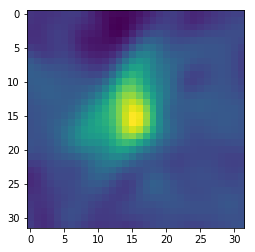

In [79]:
from skimage.transform import resize
from scipy import ndimage

X, y = DataLoader.load_train()

idx = np.random.randint(0, X.shape[0])
print(idx)
pic = X.iloc[idx].band_1


def transform(pic):
    
    pic = pic.reshape(75, 75)
    pic = ndimage.gaussian_filter(pic, sigma=(2, 2), )
    
    indxs = np.linspace(5, 70, 60, dtype=int)

    x_idx = max([{'idx': i, 'val': pic[:, i].max()} for i in indxs], key=lambda k: k['val'])['idx']
    y_idx = max([{'idx': i, 'val': pic[i, :].max()} for i in indxs], key=lambda k: k['val'])['idx']
    
    buffer = 20
    x_idx = x_idx if x_idx - buffer > 0 and x_idx + buffer < 75 else 37
    y_idx = y_idx if y_idx - buffer > 0 and y_idx + buffer < 75 else 37

    
    pic = pic[:, x_idx-buffer:x_idx+buffer]
    pic = pic[y_idx-buffer:y_idx+buffer, :]
 
    pic = resize(pic, output_shape=(32, 32), mode='reflect')
    return pic.flatten()

pic = pic.reshape(75, 75)

from scipy.misc import imresize

pic = transform(pic)
plt.imshow(pic.reshape(32, 32))

In [80]:
X, y = DataLoader.load_train()



def norm_by_pic(img):
    #img = img.reshape(75, 75)[20:55, 20:55].flatten()
    img = (img - img.min()) / (img.max() - img.min())
    return img

# Exploded embedded images so each pixel has its own column
for band in ['band_1', 'band_2']:
    X[band] = X[band].map(norm_by_pic)
    X[band] = X[band].map(transform)
    exploded = X[band].apply(pd.Series)
    exploded.columns = ['{}_pixel_{}'.format(band, col) for col in exploded.columns]
    X = X.join(exploded) \
         .drop(columns=band)
        
X['inc_angle_missing'] = X.inc_angle.map(lambda val: 1 if pd.isnull(val) else 0)
X.head()

,inc_angle,band_1_pixel_0,band_1_pixel_1,band_1_pixel_2,band_1_pixel_3,band_1_pixel_4,band_1_pixel_5,band_1_pixel_6,band_1_pixel_7,band_1_pixel_8,...,band_2_pixel_1015,band_2_pixel_1016,band_2_pixel_1017,band_2_pixel_1018,band_2_pixel_1019,band_2_pixel_1020,band_2_pixel_1021,band_2_pixel_1022,band_2_pixel_1023,inc_angle_missing
0,43.9239,0.298651,0.303977,0.307478,0.304045,0.292002,0.276557,0.263925,0.256480,0.253182,...,0.384615,0.392288,0.394090,0.387484,0.378758,0.376067,0.377878,0.376748,0.370368,0
1,38.1562,0.237387,0.246427,0.260859,0.275291,0.284003,0.284640,0.279096,0.271513,0.266830,...,0.240916,0.238942,0.244417,0.252624,0.259824,0.264287,0.266684,0.268119,0.267873,0
2,45.2859,0.389864,0.404053,0.411963,0.407728,0.398572,0.397190,0.405737,0.417818,0.426505,...,0.481904,0.481704,0.486153,0.499067,0.514016,0.520327,0.514820,0.505067,0.501147,0
3,43.8306,0.246372,0.246096,0.252000,0.258051,0.259279,0.259346,0.262998,0.268304,0.267991,...,0.285975,0.286366,0.281927,0.276523,0.274162,0.278165,0.287878,0.300008,0.311495,0
4,35.6256,0.386213,0.379652,0.366984,0.352437,0.341718,0.339542,0.344426,0.352276,0.360633,...,0.449514,0.444608,0.451449,0.463678,0.472623,0.473058,0.468419,0.464585,0.463557,0


In [123]:
from sklearn.preprocessing import (FunctionTransformer, RobustScaler as Scaler, Normalizer,
                                   QuantileTransformer, 
                                   Imputer
                                  )
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

COLUMNS = X.columns

def band1(x):
    return x[:, [i for i in range(0, len(COLUMNS)) if COLUMNS[i].startswith('band_1')]]

def band2(x):
    return x[:, [i for i in range(0, len(COLUMNS)) if COLUMNS[i].startswith('band_2')]]

def angle(x):
    return x[:, [i for i in range(0, len(COLUMNS)) if COLUMNS[i] in ['inc_angle', 'inc_angle_missing']]]

pipe = Pipeline(steps=[
    ('imputer', Imputer(strategy='median')),
    ('feature_union', FeatureUnion(n_jobs=1, transformer_list=[
        ('band_1_pipe', Pipeline(steps=[
            ('band_1', FunctionTransformer(band1)),
            ('band_1_standard_scale', Scaler()),
        ])),
        ('band_2_pipe', Pipeline(steps=[
            ('band_2', FunctionTransformer(band2)),
            ('band_2_standard_scale', Scaler()),
        ])),
        ('inc_angle', FunctionTransformer(angle))
    ])),
    ('xgboost', XGBClassifier(n_estimators=100))
])

scores = cross_val_score(pipe, X, y, scoring='neg_log_loss', cv=2)
print('Scores - Mean: {:.6f} - STD: {:.2f}'.format(scores.mean(), scores.std()))

Scores - Mean: -0.356569 - STD: 0.02


In [44]:
from sklearn.metrics import log_loss, make_scorer

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [17]:
rf = RandomForestClassifier()
rf.fit(data, target)
rf.predict_proba(data).shape

(100, 2)

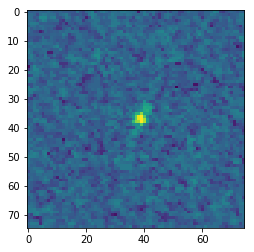

In [3]:
plt.imshow(xTest.iloc[0]['band_2'].reshape(-1, 75))
plt.show()

In [113]:
class DoubleNet(nn.Module):
    
    def __init__(self):
        super(DoubleNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Input 1 branch
        self.input1_layer1_conv2d = nn.Conv2d(in_channels=1, out_channels=8,  kernel_size=7, padding=5)
        self.input1_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
        self.input1_layer3_conv2d = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.input1_layer4_fc = nn.Linear(in_features=3200, out_features=512)
        
        # Input 2 branch
        self.input2_layer1_conv2d = nn.Conv2d(in_channels=1, out_channels=8,  kernel_size=7, padding=5)
        self.input2_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
        self.input2_layer3_conv2d = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.input2_layer4_fc = nn.Linear(in_features=3200, out_features=512)
        
        # Input 3 branch "inc_angle"
        self.input3_layer1_fc1 = nn.Linear(in_features=2, out_features=24)
        
        # Concatenated branch, fully connected stream
        self.fc1 = nn.Linear(in_features=1048, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=1)
        
    def forward(self, input1, input2, input3):
        
        input1 = self.pool(F.relu(self.input1_layer1_conv2d(input1)))
        input1 = self.pool(F.relu(self.input1_layer2_conv2d(input1)))
        input1 = self.pool(F.relu(self.input1_layer3_conv2d(input1)))
        input1 = F.relu(self.input1_layer4_fc(input1.view(-1, 3200)))
        
        input2 = self.pool(F.relu(self.input2_layer1_conv2d(input2)))
        input2 = self.pool(F.relu(self.input2_layer2_conv2d(input2)))
        input2 = self.pool(F.relu(self.input2_layer3_conv2d(input2)))
        input2 = F.relu(self.input2_layer4_fc(input2.view(-1, 3200)))
        
        input3 = self.input3_layer1_fc1(input3)
        
        combined = torch.cat((input1, input2, input3), 1)
        
        combined = (self.fc1(combined))
        combined = (self.fc2(combined))
        combined = F.sigmoid(self.fc3(combined))
        
        return combined

DoubleNet()

DoubleNet (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (input1_layer1_conv2d): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
  (input1_layer2_conv2d): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (input1_layer3_conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (input1_layer4_fc): Linear (3200 -> 512)
  (input2_layer1_conv2d): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(5, 5))
  (input2_layer2_conv2d): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (input2_layer3_conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (input2_layer4_fc): Linear (3200 -> 512)
  (input3_layer1_fc1): Linear (2 -> 24)
  (fc1): Linear (1048 -> 512)
  (fc2): Linear (512 -> 512)
  (fc3): Linear (512 -> 1)
)

(1604, 3)

In [125]:
print('transfering to cuda')
print('initializing model')
net = DoubleNet()
net.cuda()

n_epoch = 35
batch_size = 300

print('defining optimizers')
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Test data setup
print('concatenated test data')
testBand1 = np.concatenate(xTest.iloc[:]['band_1'].values, axis=0).reshape(-1, 1, 75, 75)
testBand2 = np.concatenate(xTest.iloc[:]['band_2'].values, axis=0).reshape(-1, 1, 75, 75)
testAngle = xTest.iloc[:][['inc_angle', 'inc_angle_was_null']].values.reshape(-1, 2)

print('test data to variables')
testBand1 = Variable(torch.FloatTensor(testBand1).cuda(), requires_grad=False)
testBand2 = Variable(torch.FloatTensor(testBand2).cuda(), requires_grad=False)
testAngle = Variable(torch.FloatTensor(testAngle).cuda(), requires_grad=False)

print('starting training')
for epoch in range(n_epoch):
    
    for sample in (np.random.randint(0, xTrain.shape[0], size=batch_size) 
                   for i in range(0, int(xTrain.shape[0] / batch_size))):
        
        band1 = np.concatenate(xTrain.iloc[sample]['band_1'].values, axis=0).reshape(-1, 1, 75, 75,)
        band2 = np.concatenate(xTrain.iloc[sample]['band_2'].values, axis=0).reshape(-1, 1, 75, 75,)
        angle = xTrain.iloc[sample][['inc_angle', 'inc_angle_was_null']].values.reshape(-1, 2)

        band1 = Variable(torch.FloatTensor(band1).cuda())
        band2 = Variable(torch.FloatTensor(band2).cuda())
        angle = Variable(torch.FloatTensor(angle).cuda())
        target = Variable(torch.FloatTensor(yTrain.iloc[sample].values.astype(float).reshape(-1, 1)).cuda())

        # batch step
        optimizer.zero_grad()

        out = net(band1, band2, angle)
        loss = criterion(out, target)
        loss.backward()

        optimizer.step()
    
    print('Epoch: {} - Loss: {:.6f}'.format(epoch+1, loss.data.cpu().numpy()[0]))
    

transfering to cuda
initializing model
defining optimizers
concatenated test data
test data to variables
starting training
Epoch: 1 - Loss: 2.076000
Epoch: 2 - Loss: 1.196142
Epoch: 3 - Loss: 0.870083
Epoch: 4 - Loss: 0.740674
Epoch: 5 - Loss: 0.708482
Epoch: 6 - Loss: 0.672659
Epoch: 7 - Loss: 0.705477
Epoch: 8 - Loss: 0.612550
Epoch: 9 - Loss: 0.614219
Epoch: 10 - Loss: 0.582758
Epoch: 11 - Loss: 0.553874
Epoch: 12 - Loss: 0.587189
Epoch: 13 - Loss: 0.597466
Epoch: 14 - Loss: 0.553963
Epoch: 15 - Loss: 0.563541
Epoch: 16 - Loss: 0.515052
Epoch: 17 - Loss: 0.549819
Epoch: 18 - Loss: 0.484234
Epoch: 19 - Loss: 0.501610
Epoch: 20 - Loss: 0.550184
Epoch: 21 - Loss: 0.446855
Epoch: 22 - Loss: 0.421391
Epoch: 23 - Loss: 0.551787
Epoch: 24 - Loss: 0.395196
Epoch: 25 - Loss: 0.413363
Epoch: 26 - Loss: 0.386812
Epoch: 27 - Loss: 0.402467
Epoch: 28 - Loss: 0.313353
Epoch: 29 - Loss: 0.382273
Epoch: 30 - Loss: 0.321432
Epoch: 31 - Loss: 0.267831
Epoch: 32 - Loss: 0.363179
Epoch: 33 - Loss: 0.24

In [126]:
# Check score of testing set
from sklearn.metrics import log_loss

pred = net(testBand1, testBand2, testAngle).data.cpu().numpy().squeeze()

print(pred[:10])
log_loss(yTest, pred, )

[  8.10688734e-01   9.78571117e-01   4.79852649e-13   2.29496986e-01
   7.57992625e-01   1.05010255e-25   4.22547273e-02   9.87084687e-01
   3.90100852e-02   5.29151618e-01]


0.33689655363859888

In [127]:
pred[:10]

array([  8.10688734e-01,   9.78571117e-01,   4.79852649e-13,
         2.29496986e-01,   7.57992625e-01,   1.05010255e-25,
         4.22547273e-02,   9.87084687e-01,   3.90100852e-02,
         5.29151618e-01], dtype=float32)

In [112]:
# network layer trials
input1_layer1_conv2d = nn.Conv2d(in_channels=1, out_channels=8,  kernel_size=7, padding=5)
input1_layer2_conv2d = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=3)
input1_layer3_conv2d = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

fc1 = nn.Linear(in_features=3200, out_features=512)
pool = nn.MaxPool2d(kernel_size=2, stride=2)

pics = np.concatenate(xTest.iloc[0:2]['band_2'].values, axis=0).reshape(-1, 1, 75, 75,)
pics = torch.FloatTensor(pics)
pics = Variable(pics)

pics = pool(input1_layer1_conv2d(pics))
pics = pool(input1_layer2_conv2d(pics))
pics = pool(input1_layer3_conv2d(pics))
print(pics.size())
print(np.prod(pics.size()[1:]))

fc1(pics.view(-1, 3200))

torch.Size([2, 32, 10, 10])
3200


Variable containing:
 2.3612 -1.6764  0.6856  ...   1.2746 -0.7021  0.0448
 2.2727 -1.8845  0.5845  ...   1.0592 -0.7833  0.0286
[torch.FloatTensor of size 2x512]